<a href="https://colab.research.google.com/github/Darkdew/Quora_QuestionPairs_Analysis_Project1/blob/master/Quora1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install distance

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [31]:
import distance #for computing similarities between arbitrary sequences

from subprocess import check_output #to spawn new processes, connect to their 
#input/output/error pipes, and obtain their return codes

from bs4 import BeautifulSoup

import os #provides functions for interacting with the operating system
import re #for regular expression operations
import gc #garbage collector interface

In [32]:
import plotly.offline as py #Use plotly offline to generate graphs as images
py.init_notebook_mode(connected= True) #use plotly in notebook mode offline
import plotly.graph_objs as go #An open-source, interactive graphing library for Python
import plotly.tools as tls

In [33]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Reading Data and Basic statistics

In [34]:
df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Quora_project1/Copy of train.csv')


In [35]:
print("Number of  data points= ", df.shape[0])

Number of  data points=  404290


In [36]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [37]:
# Extracting more info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [38]:
#we can see that two rows from 'question2' and 1 row from 'question1' are missing values

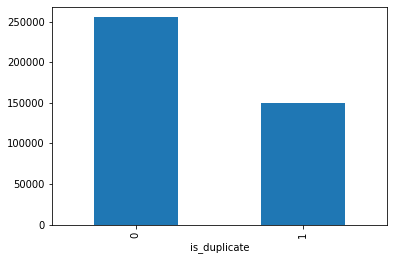

In [39]:
#now lets visualize the distribution of datapoints grouped on the output label 'is_duplicate' classes by id
df.groupby('is_duplicate')['id'].count().plot.bar()


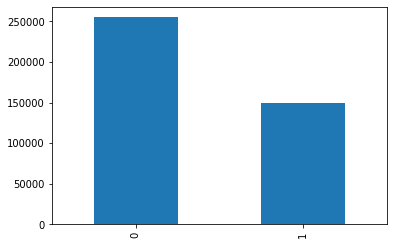

In [40]:
# the above step can be easily performed by
df['is_duplicate'].value_counts().plot.bar()

# Lets Explore our data

In [41]:
print("Total number of Question pairs for training= {} ".format(len(df)))

Total number of Question pairs for training= 404290 


In [42]:
# % of Question pairs that are similar, is_duplicate=1

is_duplicate_1_percentage= df['is_duplicate'].mean()*100
print("~> Percentage of Similar Question pairs(is_duplicate==1)= {}".format(round(is_duplicate_1_percentage,2)))

# % of Question pairs that are dissimilar, is_duplicate=0

is_duplicate_0_percentage= round(100- is_duplicate_1_percentage, 2)
print("~> Percentage of DisSimilar Question pairs(is_duplicate==0)= {}".format(is_duplicate_0_percentage))

~> Percentage of Similar Question pairs(is_duplicate==1)= 36.92
~> Percentage of DisSimilar Question pairs(is_duplicate==0)= 63.08


In [43]:
qid1_list= df['qid1'].to_list() 
qid2_list= df['qid2'].to_list()
total_qid_series= pd.Series(qid1_list + qid2_list)

#Number of Unique Questions

unique_question= len(np.unique(total_qid_series))
print("Number of unique questions: {}".format(unique_question))

#Number of Repeated Questions

repeated_questions_count= np.sum(total_qid_series.value_counts()>1)
print("Count of unique questions that are repeated: {}, ({}%)".\
      format(repeated_questions_count, \
             (repeated_questions_count/unique_question)*100))

print("Max count of times a question is repeated=",max(total_qid_series.value_counts()))


Number of unique questions: 537933
Count of unique questions that are repeated: 111780, (20.77953945937505%)
Max count of times a question is repeated= 157


In [44]:
# lets create an array for total repetition counts for each question
q_val_counts= total_qid_series.value_counts()

In [45]:
q_val_counts

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64

In [46]:
q_val_counts_values= total_qid_series.value_counts().values

In [47]:
q_val_counts_values

array([157, 120, 111, ...,   1,   1,   1])

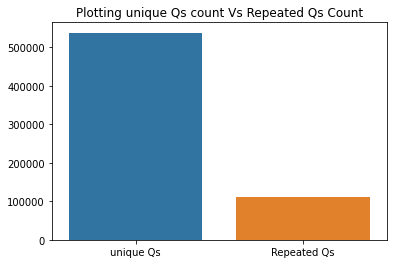

In [48]:
plt.title("Plotting unique Qs count Vs Repeated Qs Count")
sns.barplot(["unique Qs", "Repeated Qs"], [unique_question, repeated_questions_count])

# Checking for Duplicates

In [49]:
#Checking if there are any repeated pair of Qs being compared

pair_duplicates= df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()

#Reset the index of the DataFrame, and use the default one instead. 
#If the DataFrame has a MultiIndex, this method can remove one or more levels.

duplicate_pair_count= pair_duplicates.shape[0]- df.shape[0]

print("Number of duplicate Questions= ", duplicate_pair_count)

Number of duplicate Questions=  0


Max count of times a question is repeated= 157


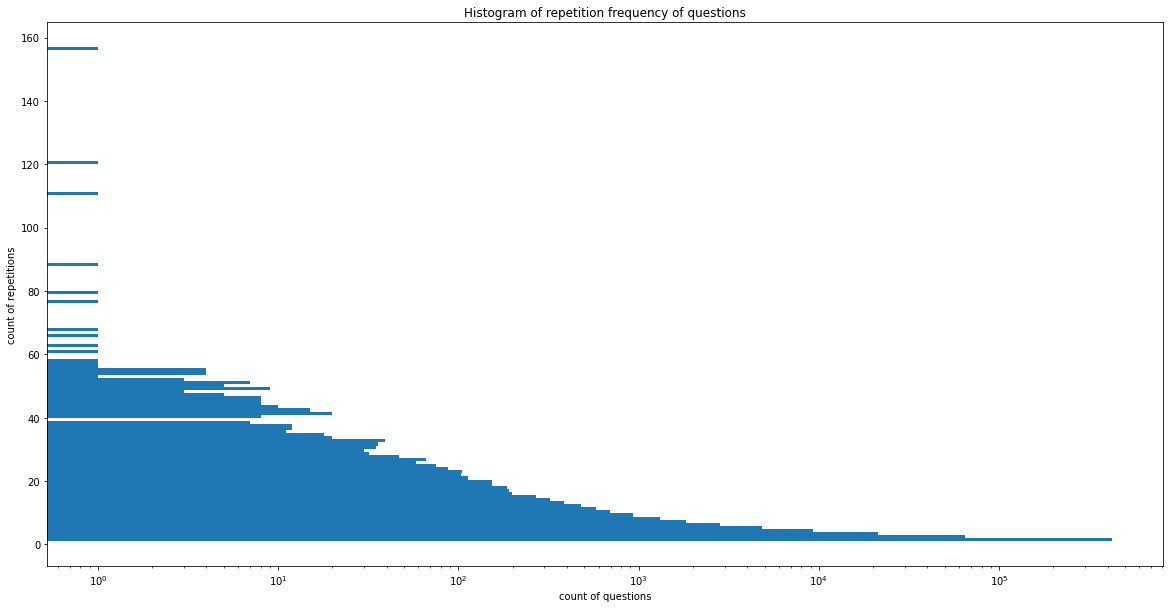

In [50]:
#Number of occurence of each question
plt.figure(figsize=(20,10))
plt.hist(total_qid_series.value_counts(), bins=160, orientation='horizontal')
plt.xscale("log")
plt.title("Histogram of repetition frequency of questions")
plt.xlabel("count of questions")
plt.ylabel("count of repetitions")
print("Max count of times a question is repeated=",max(total_qid_series.value_counts()))

# Null Values Handling

In [51]:
#Checking whether there are any rows with null values

df.isnull().any(0) # any(0) finds out null values column wise


id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

In [52]:
df.isnull().any(1) # any(1) finds out null values row wise

0         False
1         False
2         False
3         False
4         False
          ...  
404285    False
404286    False
404287    False
404288    False
404289    False
Length: 404290, dtype: bool

In [53]:
nan_rows= df[df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


- There are 3 rows with Null values in our dataframe

In [54]:
#Lets fill the null values with ' '
df= df.fillna('')

#lets check if the statement worked
nan_rows= df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# Basic Feature Extraction (Before Cleaning)

- freq_qid1 = Frequency of qid1's
- freq_qid2 = Frequency of qid2's
- q1len = Length of q1
- q2len = Length of q2
- q1_n_words = Number of words in Question 1
- q2_n_words = Number of words in Question 2
- word_Common = (Number of common unique words in Question 1 and Question 2)
- word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
- word_share = (word_common)/(word_Total)
- freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
- freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [55]:
if os.path.isfile('df_fe_beforecleaning_train.csv'):
  df= pd.read_csv('df_fe_beforecleaning_train.csv', encoding= 'latin-1')

else:
  df['freq_qid1']= df.groupby('qid1')['qid1'].transform('count') #refer pdf for groupbywith transform('count')
  df['freq_qid2']= df.groupby('qid2')['qid2'].transform('count')
# strip() strips the left and right end's white spaces for each word.
  df['q1len']= df['question1'].str.len()
  df['q2len']= df['question2'].str.len()

  df['q1_n_words']= df['question1'].apply(lambda row: len(row.split(' ')))
  df['q2_n_words']= df['question2'].apply(lambda row: len(row.split(' ')))

  def normalized_word_Common(row):
    w1= set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2= set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
    return 1.0*len(w1 & w2)

  df['word_Common']= df.apply(normalized_word_Common, axis=1)

  def normalized_word_Total(row):
    w1= set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2= set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
    return 1.0*len(w1) + len(w2)

  df['word_Total']= df.apply(normalized_word_Total, axis=1)

  def normalized_word_share(row):
    w1= set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2= set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
    return 1.0*(len(w1 & w2)/ (len(w1)+len(w2)))

  df['word_share']= df.apply(normalized_word_share, axis=1)

  df['freq_q1+q2']= df['freq_qid1']+ df['freq_qid2']
  df['freq_q1-q2']= abs(df['freq_qid1']- df['freq_qid2'])

  df.to_csv("df_fe_beforecleaning_train.csv", index= False)

df.head()


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


# Miscellaneous analysis

In [56]:
print("Min length of questions in question1 group= ", min(df['q1_n_words']))
print("Min length of questions in question2 group= ", min(df['q2_n_words']))

print('number of questions with min length [question1 group]= ', df[df['q1_n_words']==1].shape[0])
print('number of questions with min length [question2 group]= ', df[df['q2_n_words']==1].shape[0])

Min length of questions in question1 group=  1
Min length of questions in question2 group=  1
number of questions with min length [question1 group]=  67
number of questions with min length [question2 group]=  24


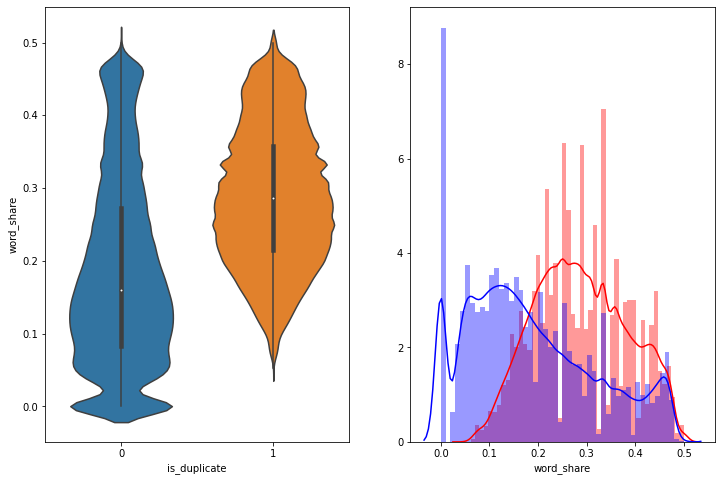

In [59]:
# Analysing word_share feature
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x=df['is_duplicate'], y= df['word_share'])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_share'], color= 'red')
sns.distplot(df[df['is_duplicate']==0]['word_share'], color= 'blue')

- The distributions for normalized word_share have some overlap towards the right, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

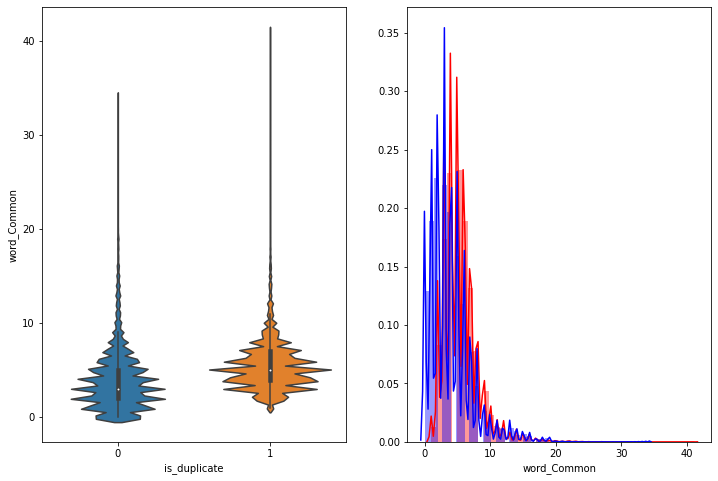

In [60]:
# Analysing word_Common feature
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x=df['is_duplicate'], y= df['word_Common'])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_Common'], color= 'red')
sns.distplot(df[df['is_duplicate']==0]['word_Common'], color= 'blue')

- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping